<a href="https://colab.research.google.com/github/Pedropicapapa5/MCD-AA2025/blob/main/Tarea5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set(style='whitegrid')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Spotify Features 3.0.csv')
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,year_release
0,Alternative,3 Doors Down,Kryptonite,6ZOBP3NvffbU4SZcrnt1k6,75,0.00664,0.545,233933,0.865,0.000011,B,0.1680,-5.708,Minor,0.0286,99.010,0.543,2000
1,Alternative,Counting Crows,Mr. Jones,5DiXcVovI0FcY2s0icWWUu,75,0.21100,0.581,272507,0.817,0.000001,C,0.2460,-6.542,Major,0.0382,141.607,0.779,1993
2,Alternative,ChocQuibTown,Pa Olvidarte (feat. Manuel Turizo) - Remix,2ktoFujjJtantyMoVdBJlX,76,0.04410,0.724,256418,0.791,0.000007,G,0.2390,-5.411,Major,0.1690,176.011,0.856,2018
3,Dance,Ariana Grande,"break up with your girlfriend, i'm bored",4kV4N9D1iKVxx1KLvtTpjS,99,0.04210,0.726,190440,0.554,0.000000,F,0.1060,-5.290,Minor,0.0917,169.999,0.335,2019
4,Dance,Ariana Grande,7 rings,14msK75pk3pA33pzPVNtBF,100,0.57800,0.725,178640,0.321,0.000000,C#,0.0884,-10.744,Minor,0.3230,70.142,0.319,2019


In [ ]:
features = ['acousticness','danceability','energy','instrumentalness','liveness',
            'loudness','speechiness','tempo','valence','duration_ms']

In [ ]:
X = df[features].dropna().copy()
ids = X.index

In [ ]:
# Escalado
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

In [ ]:
# OPTICS
opt = OPTICS(min_samples=10, xi=0.05, metric='euclidean', cluster_method='xi')  # parámetros a ajustar
opt.fit(Xs)
labels_opt = opt.labels_   # -1 -> ruido

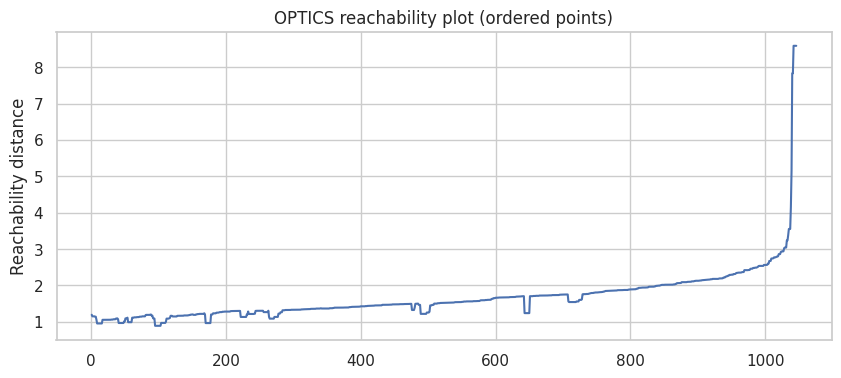

In [ ]:
# Visualización de reachability plot (útil)
reach = opt.reachability_
ordering = opt.ordering_
plt.figure(figsize=(10,4))
plt.plot(reach[ordering])
plt.ylabel('Reachability distance')
plt.title('OPTICS reachability plot (ordered points)')
plt.show()

In [ ]:
# Extraer y evaluar distintas particiones
xis = [0.01, 0.03, 0.05, 0.1]
results = []
for xi in xis:
    opt_xi = OPTICS(min_samples=10, xi=xi, cluster_method='xi')
    opt_xi.fit(Xs)
    labels = opt_xi.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters <= 1:
        sil, ch, db = (np.nan, np.nan, np.nan)
    else:
        sil = silhouette_score(Xs, labels)
        ch = calinski_harabasz_score(Xs, labels)
        db = davies_bouldin_score(Xs, labels)
    results.append({'xi': xi, 'n_clusters': n_clusters, 'silhouette': sil, 'CH': ch, 'DB': db})

res_df = pd.DataFrame(results)
print(res_df)

     xi  n_clusters  silhouette         CH        DB
0  0.01           9   -0.232497  11.032186  2.162531
1  0.03           7   -0.244072  11.285423  1.812263
2  0.05           6   -0.258746  10.992075  1.795243
3  0.10           1         NaN        NaN       NaN


In [ ]:
# Elección de la mejor partición por consenso: xi que maximiza silhouette (o CH) y minimiza DB
best_by_sil = res_df.loc[res_df['silhouette'].idxmax()]
best_by_ch = res_df.loc[res_df['CH'].idxmax()]
best_by_db = res_df.loc[res_df['DB'].idxmin()]
print('Mejor por silhouette:', best_by_sil)
print('Mejor por CH:', best_by_ch)
print('Mejor por DB:', best_by_db)

Mejor por silhouette: xi             0.010000
n_clusters     9.000000
silhouette    -0.232497
CH            11.032186
DB             2.162531
Name: 0, dtype: float64
Mejor por CH: xi             0.030000
n_clusters     7.000000
silhouette    -0.244072
CH            11.285423
DB             1.812263
Name: 1, dtype: float64
Mejor por DB: xi             0.050000
n_clusters     6.000000
silhouette    -0.258746
CH            10.992075
DB             1.795243
Name: 2, dtype: float64


In [ ]:
# Partición seleccionada (best_by_sil.xi)
best_xi = best_by_sil['xi']
opt_best = OPTICS(min_samples=10, xi=best_xi, cluster_method='xi')
opt_best.fit(Xs)
labels_best = opt_best.labels_
df_result = X.copy()
df_result['cluster'] = labels_best

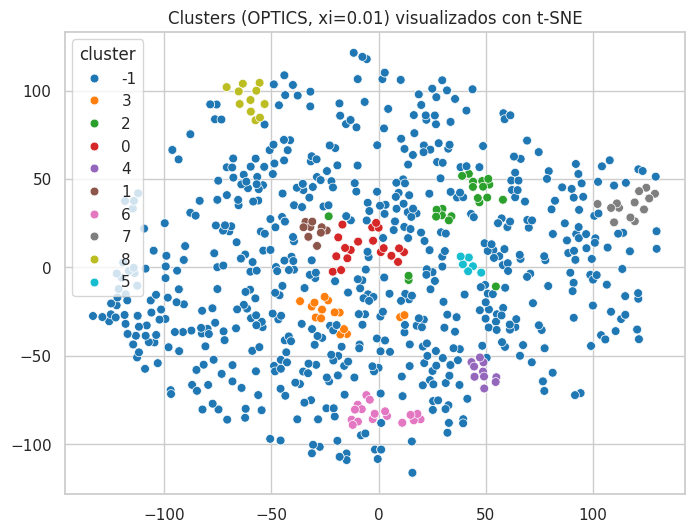

In [ ]:
# Visualización con t-SNE (reducción a 2D)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X2 = tsne.fit_transform(Xs)
plt.figure(figsize=(8,6))
palette = sns.color_palette('tab10', np.unique(labels_best).size)
sns.scatterplot(x=X2[:,0], y=X2[:,1], hue=labels_best.astype(str), palette=palette, legend='full', s=40)
plt.title(f'Clusters (OPTICS, xi={best_xi}) visualizados con t-SNE')
plt.legend(title='cluster')
plt.show()

In [ ]:
df_result['track_index'] = ids
df_result.to_csv('clusters_optics_labels.csv', index=False)
print('Etiquetas guardadas en clusters_optics_labels.csv')

Etiquetas guardadas en clusters_optics_labels.csv


In [ ]:
plt.savefig("reachability_plot.png", dpi=300, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>